This is based on our official notebook - not something I can take credit for :)
https://github.com/planetlabs/planet-amazon-deforestation/blob/master/planet_chip_examples.ipynb

# *Planet: Understanding the Amazon from Space* challenge

This notebook will show you how to do some basic manipulation of the images and label files.

## 我对这个代码通了一遍，前半部分是在分析标签，后半部分是在图像可视化，个人认为后半部分没啥用。我加了一些备注，也改了改代码，你们可以看看。

In [2]:
import sys
import os
import subprocess

from six import string_types

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

## Setup
Set `PLANET_KAGGLE_ROOT` to the proper directory where we've got the TIFF and JPEG zip files, and accompanying CSVs.

In [3]:
PLANET_KAGGLE_ROOT = os.path.abspath("../input/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

## Inspect image labels
The labels are in a CSV entitled `train.csv`. Note that each image can be tagged with multiple tags. We'll convert them to a "one hot" style representation where each label is a column:

In [4]:
#读取train set标签
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
# 创建一个list里面有所有标签
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [6]:
label_list


['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [7]:
len(label_list)

17

In [8]:
#进行one－hot编码 数据预处理
#对每一个图像的标签进行标记，有此标签为1
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
labels_df.head()#显示几个看看

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [9]:
#统计每一个单标签的图像个数
labels_df_sum=labels_df[label_list].sum().sort_values()
labels_df_sum

blow_down               98
conventional_mine      100
slash_burn             209
blooming               332
artisinal_mine         339
selective_logging      340
bare_ground            862
cloudy                2089
haze                  2697
habitation            3660
cultivation           4477
partly_cloudy         7261
water                 7411
road                  8071
agriculture          12315
clear                28431
primary              37513
dtype: int64

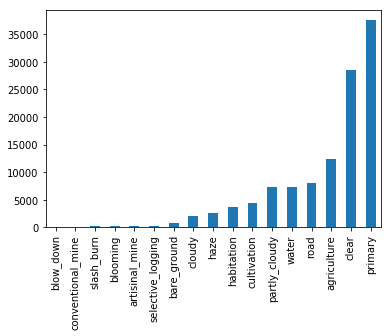

In [10]:
labels_df_sum.plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


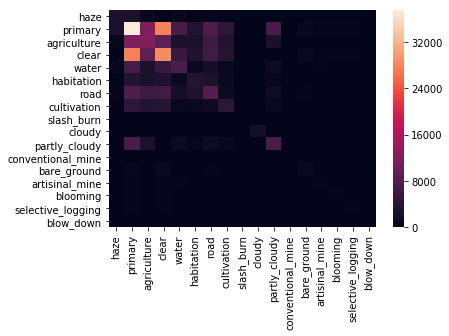

In [11]:
#统计两种标签同时出现的图像个数
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df) #转置后点积变成17*17
    sns.heatmap(c_matrix) #热力图
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

Each image should have exactly one weather label:

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


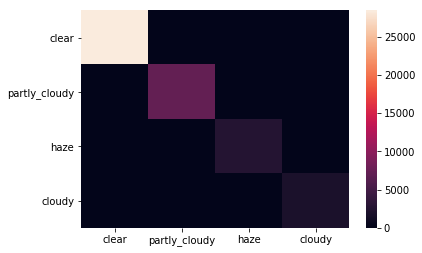

In [12]:
#有关天气的标签
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
#一个图像中有关天气的标签只有一种－－对角矩阵
make_cooccurence_matrix(weather_labels)

In [16]:
import cv2

In [21]:
# Pull a list of 20000 image names
jpg_list = os.listdir(PLANET_KAGGLE_JPEG_DIR)[:20000]
# Select a random sample of 100 among those
np.random.shuffle(jpg_list)
jpg_list = jpg_list[:100]
images = [mpimg.imread('../input/train-jpg/'+ img) for img in jpg_list]
resized_images = [np.reshape(cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA), [64,64,3]) for img in images]

ValueError: cannot reshape array of size 16384 into shape (1,64,64,3)

In [14]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras import regularizers

Using TensorFlow backend.


But the land labels may overlap:

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


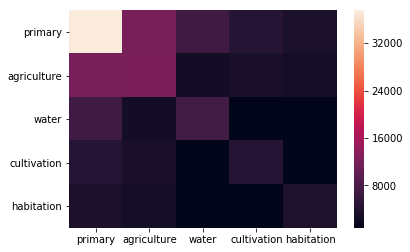

In [25]:
#有关地面类型的标签，并不是对焦矩阵，即一个图片可以表示多种地面类型
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

The rarer labels have very little overlap:

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


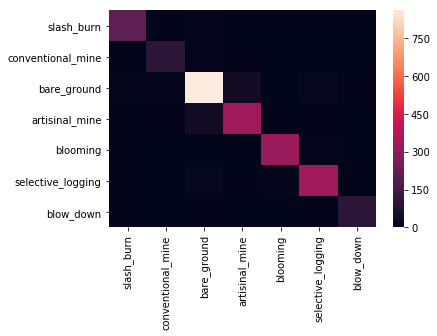

In [26]:
#含有图片比较少的标签
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)


－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－
## 讲真。。感觉下面的函数没大有用，是对图像的可视化分析，对图像做一些处理

### Inspect images
Let's display an image and visualize the pixel values. Here we will pick an image, load every single single band, then create RGB stack. These raw images are 16-bit (from 0 to 65535), and contain red, green, blue, and [Near infrared (NIR)](https://en.wikipedia.org/wiki/Infrared#Regions_within_the_infrared) channels. In this example, we are discarding the NIR band just to simplify the steps to visualize the image. However, you should probably keep it for ML classification.

The files can be easily read into numpy arrays with the skimage.

我把原来的code对图片通道分类变成了jpg的，tif的没下载，而且貌似Project Handout上建议用jpg？？

就只是改了函数中的文件后缀，你们看看。。。。

In [27]:
#获取含有tags标签的一张图片
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types): #tag是否是string类型
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [34]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)

Let's look at an individual image. First, we'll plot a histogram of pixel values in each channel. Note how the intensities are distributed in a relatively narrow region of the dynamic range

In [39]:
def plot_rgbn_histo(r, g, b):
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

Found image /Users/sunchenxi/Desktop/lab/kaggle/amazon/train-jpg/train_31654.jpg


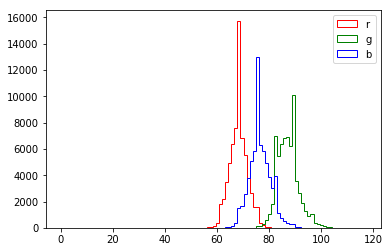

In [40]:
#读取含有'primary'and'water'and'road'的图片。
s = sample_images(['primary', 'water', 'road'], n=1)
fname = sample_to_fname(s, 0)

# find the image in the data directory and load it
# note the initial bgrn band ordering
bgrn_image = load_image(fname)

# extract the rgb values
bgr_image = bgrn_image[:,:,:3]
rgb_image = bgr_image[:, :, [2,1,0]]

# extract the different bands
b, g, r= bgrn_image[:, :, 0], bgrn_image[:, :, 1], bgrn_image[:, :, 2]

# plot a histogram of rgbn values
plot_rgbn_histo(r, g, b)

We can look at each channel individually:

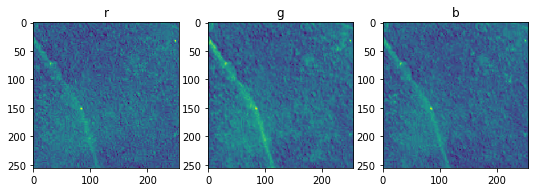

In [41]:
# Plot the bands
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), )):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

But, when we try to look at the RGB image, something funny's going on!|

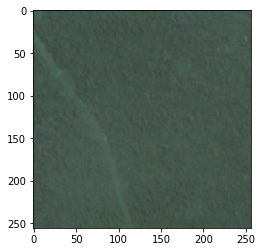

In [42]:
plt.imshow(rgb_image)

### Calibrate colors for visual inspection

Yikes! That does not look pretty. This is not a problem for analytic purposes, but we can try some transformations to make the image look better for visual inspection.

One way of doing this is to normalize the image channels to a reference color curve. We'll show here how to estimate a reference color curve from other normalized images. We could choose a third party aerial image of a canopy , but here we will employ the JPEG images provided in the data set, which have already been color-corrected.  

In essence, the idea is to transform the pixel values of the test image so that their average and variance match the reference image data.

Get a list of reference images to extract data from:

In [46]:
# Pull a list of 20000 image names
jpg_list = os.listdir(PLANET_KAGGLE_JPEG_DIR)[:20000]
# Select a random sample of 100 among those
np.random.shuffle(jpg_list)
jpg_list = jpg_list[:100]

In [47]:
print(jpg_list)

['train_11611.jpg', 'train_26415.jpg', 'train_25714.jpg', 'train_19406.jpg', 'train_1408.jpg', 'train_20157.jpg', 'train_15948.jpg', 'train_16950.jpg', 'train_17617.jpg', 'train_24175.jpg', 'train_16245.jpg', 'train_23091.jpg', 'train_11008.jpg', 'train_17174.jpg', 'train_14355.jpg', 'train_15880.jpg', 'train_26957.jpg', 'train_11484.jpg', 'train_26826.jpg', 'train_1461.jpg', 'train_14562.jpg', 'train_18567.jpg', 'train_16968.jpg', 'train_2584.jpg', 'train_27356.jpg', 'train_11910.jpg', 'train_22125.jpg', 'train_22732.jpg', 'train_26385.jpg', 'train_15760.jpg', 'train_21800.jpg', 'train_15876.jpg', 'train_22803.jpg', 'train_1541.jpg', 'train_19132.jpg', 'train_26036.jpg', 'train_1079.jpg', 'train_15545.jpg', 'train_24733.jpg', 'train_1712.jpg', 'train_18881.jpg', 'train_15868.jpg', 'train_20295.jpg', 'train_23619.jpg', 'train_23119.jpg', 'train_20912.jpg', 'train_20630.jpg', 'train_19379.jpg', 'train_14724.jpg', 'train_24394.jpg', 'train_24043.jpg', 'train_12220.jpg', 'train_12657.jpg'

Read each image (8-bit RGBA) and dump the pixels values to ref_colors, which contains buckets for R, G and B

In [48]:
ref_colors = [[],[],[]]
for _file in jpg_list:
    # keep only the first 3 bands, RGB
    #mpimg.imread()返回np.array类型,第一维和第二维是横纵坐标，第三维是通道值。此时获得第三位的前三个通道，即rgb值
    _img = mpimg.imread(os.path.join(PLANET_KAGGLE_JPEG_DIR, _file))[:,:,:3]
    # Flatten 2-D to 1-D，三列，行数自动拟合。其实就是横坐标为每个像素点，纵坐标是rgb，值是像素点对应的rgb值
    _data = _img.reshape((-1,3))
    # Dump pixel values to aggregation buckets 放入ref_colors。
    #rgb为三行，每一行是每个像素点相对应rgb的值
    for i in range(3): 
        ref_colors[i] = ref_colors[i] + _data[:,i].tolist()
    
ref_colors = np.array(ref_colors)

Visualize the histogram of the reference data

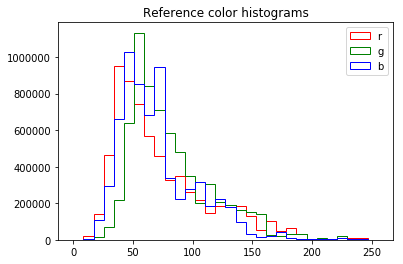

In [49]:
#统计对应rgb值的像素点的个数
for i,color in enumerate(['r','g','b']):
    plt.hist(ref_colors[i], bins=30, range=[0,255], label=color, color=color, histtype='step')
plt.legend()
plt.title('Reference color histograms')

Compute the mean and variance for each channel in the reference data

In [50]:
#计算通道均值
ref_means = [np.mean(ref_colors[i]) for i in range(3)]
ref_stds = [np.std(ref_colors[i]) for i in range(3)]

And now, we have a function that can calibrate any raw image reasonably well:

In [51]:
#图像标准化，通过均值和标准差进行平滑
def calibrate_image(rgb_image):
    # Transform test image to 32-bit floats to avoid 
    # surprises when doing arithmetic with it 
    calibrated_img = rgb_image.copy().astype('float32')

    # Loop over RGB
    for i in range(3):
        # Subtract mean 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]-np.mean(calibrated_img[:,:,i])
        # Normalize variance
        calibrated_img[:,:,i] = calibrated_img[:,:,i]/np.std(calibrated_img[:,:,i])
        # Scale to reference 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]*ref_stds[i] + ref_means[i]
        # Clip any values going out of the valid range
        calibrated_img[:,:,i] = np.clip(calibrated_img[:,:,i],0,255)#小于0的赋值为0，大于255的赋值为255

    # Convert to 8-bit unsigned int 因为图片的单通道值时8bit unsigned值
    return calibrated_img.astype('uint8')

Visualize the color histogram of the newly calibrated test image, and note that it's more evenly distributed throughout the dynamic range, and is closer to the reference data.

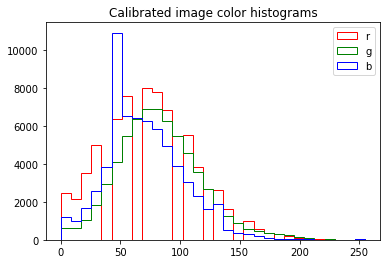

In [52]:
test_image_calibrated = calibrate_image(rgb_image)
for i,color in enumerate(['r','g','b']):
    plt.hist(test_image_calibrated[:,:,i].ravel(), bins=30, range=[0,255], 
             label=color, color=color, histtype='step')
plt.legend()
plt.title('Calibrated image color histograms')

And now we have something we can recognize!

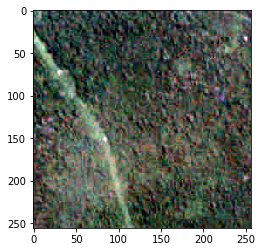

In [53]:
plt.imshow(test_image_calibrated)

Putting it all together, to show several images with your tags of choice. You may notice that the jpgs and tifs look a bit different. You can read about why that is here:
    
[A Hands-on Guide to Color Correction](https://www.planet.com/pulse/color-correction/)

Found image /Users/sunchenxi/Desktop/lab/kaggle/amazon/train-jpg/train_5036.jpg
Found image /Users/sunchenxi/Desktop/lab/kaggle/amazon/train-jpg/train_5036.jpg
Found image /Users/sunchenxi/Desktop/lab/kaggle/amazon/train-jpg/train_5036.jpg


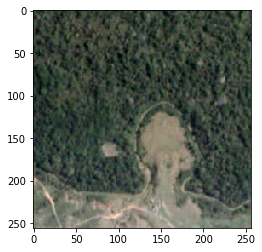

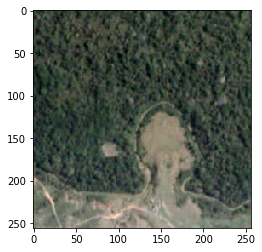

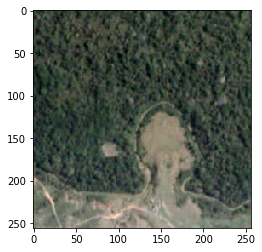

In [55]:
sampled_images = sample_images(['clear', 'road', 'water'], n=3)

for i in range(len(sampled_images)):
    #tif = sample_to_fname(sampled_images, i, 'tif')
    jg = sample_to_fname(sampled_images, i, 'jpg')

    try:
       # tif_img = load_image(tif)[:,:,:3]
        jpg_img = load_image(jpg)[:,:,:3]

        #fig = plt.figure()
        #plt.imshow(calibrate_image(tif_img))

        fig = plt.figure()
        plt.imshow(calibrate_image(jpg_img))
    except:
        continue
        
        

## Image modification

You might want to rotate, flip, or otherwise modify the images for training purposes. Note that the dimensions of the image changes:

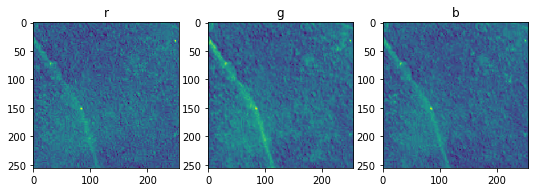

In [57]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

(362, 362, 3)

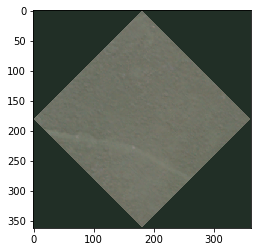

In [58]:
rotated = scipy.ndimage.rotate(rgb_image, angle=45)
plt.imshow(rgb_image)
plt.imshow(calibrate_image(rotated))
rotated.shape

## 此处旋转好像是他提醒在学习的时候对于线这种特征要用多个核来学习。就像上图的路，在不同图片中，路的方向不同，在学习的时候要学习到不同方向的路，因此要多个特征函数。貌似cnn会对一个特征用多核？ 我们不用对图像旋转处理。 所以我们学学怎么用tensorflow或者caffe或者keras中的cnn吧，我们可以去找一些简单的cnn的code学学。

Original Notebook by Jesus Martinez Manso and Benjamin Goldenberg

(C) Planet 2017